In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import xarray as xr
import cftime
import cartopy.crs as ccrs
from scipy.spatial import cKDTree
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cf
from matplotlib.colors import BoundaryNorm
import matplotlib.cm as cm
from scipy.stats import pearsonr, kendalltau, spearmanr
from geopy.geocoders import Nominatim
from geopy.exc import GeocoderTimedOut
import time
import geopandas as gpd

# Yields

### Process New Ljungqvist Data

In [2]:
base_path = 'data/fcl_yields_new'

type_map = {
    'yieldratio': 'YR',
    'yields': 'YI',
    'tithes': 'TI'
}

grain_choices = ['Oats', 'Wheat', 'Barley', 'Rye', 'Spelt', 'Rice', 'Maize']

# Geocoding setup
geolocator = Nominatim(user_agent="fcl_yield_mapper")
geocode_cache = {}

def geocode_city(city_name, retries=3, delay=2):
    if city_name in geocode_cache:
        return geocode_cache[city_name]

    for attempt in range(retries):
        try:
            location = geolocator.geocode(city_name, timeout=10)
            if location:
                coords = {'Latitude': location.latitude, 'Longitude': location.longitude}
            else:
                coords = {'Latitude': None, 'Longitude': None}
            geocode_cache[city_name] = coords
            return coords
        except GeocoderTimedOut:
            print(f"Timeout for {city_name}, retrying ({attempt+1}/{retries})...")
            time.sleep(delay)
        except Exception as e:
            print(f"Failed to geocode {city_name}: {e}")
            break

    coords = {'Latitude': None, 'Longitude': None}
    geocode_cache[city_name] = coords
    return coords


final_rows = []

for folder, type_value in type_map.items():
    folder_path = os.path.join(base_path, folder)
    if not os.path.isdir(folder_path):
        print(f"Skipping missing folder: {folder_path}")
        continue

    for filename in os.listdir(folder_path):
        file_path = os.path.join(folder_path, filename)
        name, ext = os.path.splitext(filename)
        if ext not in ['.xlsx', '.txt']:
            continue

        # Read file
        if ext == '.xlsx':
            df = pd.read_excel(file_path)
        else:
            df = pd.read_csv(file_path, delimiter='\t', engine='python')

        city = name.rsplit('_', 1)[0]
        coords = geocode_city(city)

        if 'Year' not in df.columns:
            print(f"Skipping {filename}: no 'Year' column")
            continue

        id_vars = ['Year']
        value_vars = [col for col in df.columns if col not in id_vars]

        # Melt wide to long format: one row per Year-Grain combo
        long_df = df.melt(id_vars=id_vars, value_vars=value_vars,
                          var_name='Grain', value_name='MeasuredValue')

        # Add metadata columns
        long_df['Latitude'] = coords['Latitude']
        long_df['Longitude'] = coords['Longitude']
        long_df['Var'] = type_value
        long_df['Location'] = city
        long_df.rename(columns={'MeasuredValue': 'Value'}, inplace=True)

        # Normalize Grain names — use 'Other' if not in grain_choices
        def identify_grain(col_name):
            for grain in grain_choices:
                if grain.lower() in col_name.lower():
                    return grain
            return 'Other'

        long_df['Grain'] = long_df['Grain'].apply(identify_grain)

        final_rows.append(long_df)

# Combine all into one DataFrame
all_new_yields = pd.concat(final_rows, ignore_index=True)
all_new_yields['LocationGrain'] = all_new_yields['Location'] + all_new_yields['Grain']
all_new_yields['VarLocationGrain'] = all_new_yields['Var'] + all_new_yields['LocationGrain'] 

In [3]:
# clean up years & ensure only numeric year column captured
all_new_yields = all_new_yields[pd.to_numeric(all_new_yields['Year'], errors='coerce').notna()]
all_new_yields['Year'] = all_new_yields['Year'].astype(int)
all_new_yields = all_new_yields[(all_new_yields['Year'] >= 1500) & (all_new_yields['Year'] <= 1800)]
all_new_yields = all_new_yields.sort_values(by='Year').reset_index(drop=True)
all_new_yields

,Year,Grain,Value,Latitude,Longitude,Var,Location,LocationGrain,VarLocationGrain
0,1500,Other,1170.0,49.679313,6.443098,TI,Grevenmacher,GrevenmacherOther,TIGrevenmacherOther
1,1500,Other,NaN,43.312470,3.470779,TI,Agde,AgdeOther,TIAgdeOther
2,1500,Other,NaN,47.680306,16.598346,TI,Sopron,SopronOther,TISopronOther
3,1500,Other,NaN,48.584614,7.750713,TI,Strasbourg,StrasbourgOther,TIStrasbourgOther
4,1500,Oats,NaN,39.613432,2.882919,TI,Mallorca,MallorcaOats,TIMallorcaOats
...,...,...,...,...,...,...,...,...,...
7220,1800,Oats,94.814,39.613432,2.882919,TI,Mallorca,MallorcaOats,TIMallorcaOats
7221,1800,Other,124.3,38.756786,-0.004481,TI,La Marina Alta,La Marina AltaOther,TILa Marina AltaOther
7222,1800,Other,158.5,42.175682,0.703402,TI,Les Riberes,Les RiberesOther,TILes RiberesOther
7223,1800,Other,149.1,38.988139,-0.221347,TI,La Safor,La SaforOther,TILa SaforOther


In [4]:
all_new_yields[all_new_yields['LocationGrain'].str.contains('Siena', case=False, na=False)]

,Year,Grain,Value,Latitude,Longitude,Var,Location,LocationGrain,VarLocationGrain
547,1546,Other,1505,43.167206,11.467561,YI,Siena,SienaOther,YISienaOther
559,1547,Other,NaN,43.167206,11.467561,YI,Siena,SienaOther,YISienaOther
578,1548,Other,NaN,43.167206,11.467561,YI,Siena,SienaOther,YISienaOther
584,1549,Other,1085.22,43.167206,11.467561,YI,Siena,SienaOther,YISienaOther
606,1550,Other,724.22,43.167206,11.467561,YI,Siena,SienaOther,YISienaOther
...,...,...,...,...,...,...,...,...,...
2470,1663,Other,1461.7,43.167206,11.467561,YI,Siena,SienaOther,YISienaOther
2504,1664,Other,1156.22,43.167206,11.467561,YI,Siena,SienaOther,YISienaOther
2514,1665,Other,1320.16,43.167206,11.467561,YI,Siena,SienaOther,YISienaOther
2524,1666,Other,1270.1,43.167206,11.467561,YI,Siena,SienaOther,YISienaOther


In [5]:
#check for duplicates
dupes = all_new_yields[all_new_yields.duplicated(subset=['Year', 'Grain', 'LocationGrain','VarLocationGrain'], keep=False)]

# Show duplicates
print(f"Found {len(dupes)} duplicate rows:")
print(dupes.sort_values(by=['LocationGrain', 'Grain', 'Year']))

Found 0 duplicate rows:
Empty DataFrame
Columns: [Year, Grain, Value, Latitude, Longitude, Var, Location, LocationGrain, VarLocationGrain]
Index: []


In [6]:
all_new_yields

,Year,Grain,Value,Latitude,Longitude,Var,Location,LocationGrain,VarLocationGrain
0,1500,Other,1170.0,49.679313,6.443098,TI,Grevenmacher,GrevenmacherOther,TIGrevenmacherOther
1,1500,Other,NaN,43.312470,3.470779,TI,Agde,AgdeOther,TIAgdeOther
2,1500,Other,NaN,47.680306,16.598346,TI,Sopron,SopronOther,TISopronOther
3,1500,Other,NaN,48.584614,7.750713,TI,Strasbourg,StrasbourgOther,TIStrasbourgOther
4,1500,Oats,NaN,39.613432,2.882919,TI,Mallorca,MallorcaOats,TIMallorcaOats
...,...,...,...,...,...,...,...,...,...
7220,1800,Oats,94.814,39.613432,2.882919,TI,Mallorca,MallorcaOats,TIMallorcaOats
7221,1800,Other,124.3,38.756786,-0.004481,TI,La Marina Alta,La Marina AltaOther,TILa Marina AltaOther
7222,1800,Other,158.5,42.175682,0.703402,TI,Les Riberes,Les RiberesOther,TILes RiberesOther
7223,1800,Other,149.1,38.988139,-0.221347,TI,La Safor,La SaforOther,TILa SaforOther


In [7]:
# Load the data
df = pd.read_csv('data/Data_Ljungqvist_et_al_2023.csv')

#drop rwos that are all NaN
df = df.dropna(axis=0, how='all')

# Step 1: Clean column names
def clean_col(col):
    parts = col.split('_')
    if len(parts) > 2:
        return '_'.join(parts[:2]) + ''.join(parts[2:])
    else:
        return col
    
    #rename Unnamed: 0 to Year
df.rename(columns={'Unnamed: 0': 'Year'}, inplace=True)

cleaned_columns = [clean_col(c) for c in df.columns]
df.columns = cleaned_columns

# Step 2: Create Latitude and Longitude columns
latitude = df.loc[df['Year'] == 'Latitude']
longitude = df.loc[df['Year'] == 'Longitude']

# Remove these rows from df (keep only actual data)
df = df[~df['Year'].isin(['Latitude', 'Longitude',"Year"])]

# Set year as index
df = df.set_index('Year')

df = df.dropna(axis=0, how='all')  # Drop columns that are all NaN


# Melt the dataframe to long format
df_long = df.reset_index().melt(id_vars=['Year'], value_vars=df.columns,
                                var_name='VarLocationGrain', value_name='Value')

# Step 4: Add latitude and longitude info
# Flatten latitude and longitude rows to dicts
lat_dict = latitude.set_index('Year').to_dict(orient='records')[0]
lon_dict = longitude.set_index('Year').to_dict(orient='records')[0]

# Map latitude and longitude into the long dataframe
df_long['Latitude'] = df_long['VarLocationGrain'].map(lat_dict)
df_long['Longitude'] = df_long['VarLocationGrain'].map(lon_dict)

# Final result
df_long

,Year,VarLocationGrain,Value,Latitude,Longitude
0,1500,TI_WheatPuebladeGuzman,NaN,37.6100,-7.2500
1,1501,TI_WheatPuebladeGuzman,NaN,37.6100,-7.2500
2,1502,TI_WheatPuebladeGuzman,NaN,37.6100,-7.2500
3,1503,TI_WheatPuebladeGuzman,NaN,37.6100,-7.2500
4,1504,TI_WheatPuebladeGuzman,NaN,37.6100,-7.2500
...,...,...,...,...,...
27711,1833,YR_WheatSpainRinconadaAlta,NaN,37.4873,-5.9816
27712,1834,YR_WheatSpainRinconadaAlta,NaN,37.4873,-5.9816
27713,1835,YR_WheatSpainRinconadaAlta,NaN,37.4873,-5.9816
27714,1836,YR_WheatSpainRinconadaAlta,NaN,37.4873,-5.9816


In [8]:
# Split VarLocationGrain into Var and LocationGrain
df_long[['Var', 'LocationGrain']] = df_long['VarLocationGrain'].str.split('_', n=1, expand=True)

In [9]:
df_long

,Year,VarLocationGrain,Value,Latitude,Longitude,Var,LocationGrain
0,1500,TI_WheatPuebladeGuzman,NaN,37.6100,-7.2500,TI,WheatPuebladeGuzman
1,1501,TI_WheatPuebladeGuzman,NaN,37.6100,-7.2500,TI,WheatPuebladeGuzman
2,1502,TI_WheatPuebladeGuzman,NaN,37.6100,-7.2500,TI,WheatPuebladeGuzman
3,1503,TI_WheatPuebladeGuzman,NaN,37.6100,-7.2500,TI,WheatPuebladeGuzman
4,1504,TI_WheatPuebladeGuzman,NaN,37.6100,-7.2500,TI,WheatPuebladeGuzman
...,...,...,...,...,...,...,...
27711,1833,YR_WheatSpainRinconadaAlta,NaN,37.4873,-5.9816,YR,WheatSpainRinconadaAlta
27712,1834,YR_WheatSpainRinconadaAlta,NaN,37.4873,-5.9816,YR,WheatSpainRinconadaAlta
27713,1835,YR_WheatSpainRinconadaAlta,NaN,37.4873,-5.9816,YR,WheatSpainRinconadaAlta
27714,1836,YR_WheatSpainRinconadaAlta,NaN,37.4873,-5.9816,YR,WheatSpainRinconadaAlta


In [10]:
conditions = [
    df_long['LocationGrain'].str.contains('Oats', case=False, na=False),
    df_long['LocationGrain'].str.contains('Wheat', case=False, na=False),
    df_long['LocationGrain'].str.contains('Barley', case=False, na=False),
    df_long['LocationGrain'].str.contains('Rye', case=False, na=False),
    df_long['LocationGrain'].str.contains('Spelt', case=False, na=False),
    df_long['LocationGrain'].str.contains('Other', case=False, na=False),
]

# Corresponding grain names
choices = ['Oats', 'Wheat', 'Barley', 'Rye', 'Spelt', 'Other']

# Create the new column
df_long['Grain'] = np.select(conditions, choices, default='Unknown')
df_long.head(20)

,Year,VarLocationGrain,Value,Latitude,Longitude,Var,LocationGrain,Grain
0,1500,TI_WheatPuebladeGuzman,NaN,37.61,-7.25,TI,WheatPuebladeGuzman,Wheat
1,1501,TI_WheatPuebladeGuzman,NaN,37.61,-7.25,TI,WheatPuebladeGuzman,Wheat
2,1502,TI_WheatPuebladeGuzman,NaN,37.61,-7.25,TI,WheatPuebladeGuzman,Wheat
3,1503,TI_WheatPuebladeGuzman,NaN,37.61,-7.25,TI,WheatPuebladeGuzman,Wheat
4,1504,TI_WheatPuebladeGuzman,NaN,37.61,-7.25,TI,WheatPuebladeGuzman,Wheat
5,1505,TI_WheatPuebladeGuzman,NaN,37.61,-7.25,TI,WheatPuebladeGuzman,Wheat
6,1506,TI_WheatPuebladeGuzman,NaN,37.61,-7.25,TI,WheatPuebladeGuzman,Wheat
7,1507,TI_WheatPuebladeGuzman,NaN,37.61,-7.25,TI,WheatPuebladeGuzman,Wheat
8,1508,TI_WheatPuebladeGuzman,NaN,37.61,-7.25,TI,WheatPuebladeGuzman,Wheat
9,1509,TI_WheatPuebladeGuzman,NaN,37.61,-7.25,TI,WheatPuebladeGuzman,Wheat


### Merge all datasets together (new ljungqvist & 2023 dataset)

In [11]:
combined = pd.concat([all_new_yields, df_long], ignore_index=True)
print(combined.columns)
print(combined.isna().sum())  # See how many NaNs per column
combined

Index(['Year', 'Grain', 'Value', 'Latitude', 'Longitude', 'Var', 'Location',
       'LocationGrain', 'VarLocationGrain'],
      dtype='object')
Year                    0
Grain                   0
Value               15479
Latitude                0
Longitude               0
Var                     0
Location            27716
LocationGrain           0
VarLocationGrain        0
dtype: int64


,Year,Grain,Value,Latitude,Longitude,Var,Location,LocationGrain,VarLocationGrain
0,1500,Other,1170.0,49.679313,6.443098,TI,Grevenmacher,GrevenmacherOther,TIGrevenmacherOther
1,1500,Other,NaN,43.312470,3.470779,TI,Agde,AgdeOther,TIAgdeOther
2,1500,Other,NaN,47.680306,16.598346,TI,Sopron,SopronOther,TISopronOther
3,1500,Other,NaN,48.584614,7.750713,TI,Strasbourg,StrasbourgOther,TIStrasbourgOther
4,1500,Oats,NaN,39.613432,2.882919,TI,Mallorca,MallorcaOats,TIMallorcaOats
...,...,...,...,...,...,...,...,...,...
34936,1833,Wheat,NaN,37.487300,-5.981600,YR,NaN,WheatSpainRinconadaAlta,YR_WheatSpainRinconadaAlta
34937,1834,Wheat,NaN,37.487300,-5.981600,YR,NaN,WheatSpainRinconadaAlta,YR_WheatSpainRinconadaAlta
34938,1835,Wheat,NaN,37.487300,-5.981600,YR,NaN,WheatSpainRinconadaAlta,YR_WheatSpainRinconadaAlta
34939,1836,Wheat,NaN,37.487300,-5.981600,YR,NaN,WheatSpainRinconadaAlta,YR_WheatSpainRinconadaAlta


In [12]:
combined[combined['LocationGrain'].str.contains('Siena', case=False, na=False)]


,Year,Grain,Value,Latitude,Longitude,Var,Location,LocationGrain,VarLocationGrain
547,1546,Other,1505,43.167206,11.467561,YI,Siena,SienaOther,YISienaOther
559,1547,Other,NaN,43.167206,11.467561,YI,Siena,SienaOther,YISienaOther
578,1548,Other,NaN,43.167206,11.467561,YI,Siena,SienaOther,YISienaOther
584,1549,Other,1085.22,43.167206,11.467561,YI,Siena,SienaOther,YISienaOther
606,1550,Other,724.22,43.167206,11.467561,YI,Siena,SienaOther,YISienaOther
...,...,...,...,...,...,...,...,...,...
2470,1663,Other,1461.7,43.167206,11.467561,YI,Siena,SienaOther,YISienaOther
2504,1664,Other,1156.22,43.167206,11.467561,YI,Siena,SienaOther,YISienaOther
2514,1665,Other,1320.16,43.167206,11.467561,YI,Siena,SienaOther,YISienaOther
2524,1666,Other,1270.1,43.167206,11.467561,YI,Siena,SienaOther,YISienaOther


In [13]:
# Split into TI and YR and YI datasets
df_ti = combined[combined['Var'] == 'TI'].drop(columns=['Var'])
df_ti['Type'] = 'TI'
df_yr = combined[combined['Var'] == 'YR'].drop(columns=['Var'])
df_yr['Type'] = 'YR'
df_yi = combined[combined['Var'] == 'YI'].drop(columns=['Var'])
df_yi['Type'] = 'YI'


# Drop non-numeric columns before grouping
df_ti_for_grouping = df_ti.drop(columns=['VarLocationGrain', 'LocationGrain','Location','Type','Grain'])
df_yr_for_grouping = df_yr.drop(columns=['VarLocationGrain','LocationGrain','Location','Type','Grain'])
df_yi_for_grouping = df_yr.drop(columns=['VarLocationGrain','LocationGrain','Location','Type','Grain'])

# Group by Latitude, Longitude, Year and take mean
df_ti_grouped = df_ti_for_grouping.groupby(['Latitude', 'Longitude', 'Year'], as_index=False).mean()
df_yr_grouped = df_yr_for_grouping.groupby(['Latitude', 'Longitude', 'Year'], as_index=False).mean()
df_yi_grouped = df_yi_for_grouping.groupby(['Latitude','Longitude', 'Year'], as_index=False).mean()

df_ti_grouped = df_ti
df_yr_grouped = df_yr
df_yi_grouped = df_yi

#encode the different locations in the latitude and longitude columns
#concatenate the two dataframes and add a column to indicate the type of data
df_ti_grouped['Type'] = 'TI'
df_yr_grouped['Type'] = 'YR'
df_yi_grouped['Type'] = 'YI'
df_combined = pd.concat([df_ti_grouped, df_yr_grouped, df_yi_grouped], ignore_index=True)
df_combined['loc_id'] = df_combined.groupby(['Latitude', 'Longitude']).ngroup()
df_combined['Year'] = df_combined["Year"].astype(int)
df_combined = df_combined[df_combined['Year'] <= 1800]

In [14]:

print("Number of unique Latitude/Longitude pairs:", df_combined[['Latitude', 'Longitude']].drop_duplicates().shape[0])
print("Number of unique loc_id values:", df_combined['loc_id'].nunique())
print("Number of unique Years:", df_combined['Year'].nunique())

Number of unique Latitude/Longitude pairs: 86
Number of unique loc_id values: 86
Number of unique Years: 301


# ENSO

In [15]:
enso3 = pd.read_csv("data/cook2024-R15-ENSO-Rec-1500-2000.txt", delimiter="\t", comment="#", na_values="NA")
lat_lon = pd.read_csv("data/cook2024-ENSO-latlon.txt", delimiter="\t", comment="#", na_values="NA")

# Melt the ENSO DataFrame to long format
enso_melted = enso3.melt(id_vars=["Year"], var_name="gridpoint", value_name="enso")
enso_melted["gridpoint"] = enso_melted["gridpoint"].astype(int)

# Merge with the lat/lon DataFrame
enso_merged = enso_melted.merge(lat_lon, on="gridpoint")

# Convert to xarray
enso_xr = enso_merged.set_index(["Year", "lat", "lon"])["enso"].to_xarray()

enso_xr = enso_xr  - enso_xr.sel(Year=slice(1801, 1900)).mean(dim="Year")

nino3 = enso_xr.sel(lat=slice(-5, 5), lon=slice(-150, -90)).mean(dim=["lat", "lon"])
nino34 = enso_xr.sel(lat=slice(-5, 5), lon=slice(-170, -120)).mean(dim=["lat", "lon"])
nino4 = enso_xr.sel(lat=slice(-5, 5), lon = slice(-200, -150)).mean(dim=["lat", "lon"])
nino12 = enso_xr.sel(lat=slice(-10, 0), lon=slice(-90, -80)).mean(dim=["lat", "lon"])

enso = pd.merge(nino3.to_dataframe().reset_index().rename(columns={"enso": "nino3"}), nino34.to_dataframe().reset_index().rename(columns={"enso": "nino34"}), on="Year")
enso = pd.merge(enso, nino4.to_dataframe().reset_index().rename(columns={"enso": "nino4"}), on="Year")
enso = pd.merge(enso, nino12.to_dataframe().reset_index().rename(columns={"enso": "nino12"}), on="Year")

# NAO JSL

In [16]:
jsl = pd.read_excel("data/reconstructed EU JSL.xlsx")

nao_cal = pd.read_excel("data/nao_reconst.xlsx", sheet_name="Figure 2a", header=3)
nao_cal = nao_cal.rename(columns={"Time (years AD)" : "Year"})
nao_model = pd.read_excel("data/nao_reconst.xlsx", sheet_name="Figure 2b", header=3)
nao_model = nao_model.rename(columns={"Time (years AD)" : "Year"})

nao = pd.merge(nao_cal, nao_model, on="Year", suffixes=('_cal', '_model'))

nao = nao.rename(columns={"Ensemble Mean_cal" : "NAO_cal", "Ensemble Mean_model" : "NAO_model"})[["Year", "NAO_cal", "NAO_model"]]

C:\Users\emile\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\openpyxl\worksheet\_reader.py:329: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)
C:\Users\emile\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\openpyxl\worksheet\_reader.py:329: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


# Conflict

C:\Users\emile\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\openpyxl\worksheet\_reader.py:329: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)
C:\Users\emile\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\openpyxl\worksheet\_reader.py:329: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


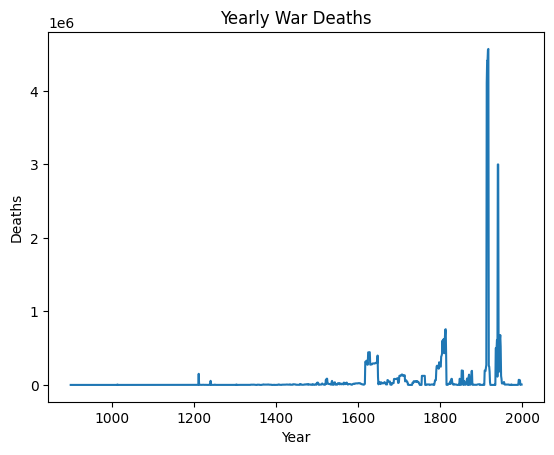

In [17]:
# Load the data
post1400 = pd.read_excel('data/Conflict-Catalog-18-vars.xlsx')
pre1400 = pd.read_excel('data/Brecke-Pre-1400-European-Conflicts.xlsx')


# Convert StartYear and EndYear to integer if not NaN
post1400['StartYear'] = post1400['StartYear'].apply(lambda x: int(x) if not pd.isna(x) else np.nan)
post1400['EndYear'] = post1400['EndYear'].apply(lambda x: int(x) if not pd.isna(x) else np.nan)

# Filter Region to be 3 and 4
post1400 = post1400[post1400['Region'].isin([3, 4])]
# Select relevant columns
post1400 = post1400[['TotalFatalities', 'MilFatalities', 'StartYear', 'EndYear']].copy()
pre1400 = pre1400[['Fatalities', 'StartYear', 'EndYear']].copy()

# Fill NaN values in TotalFatalities and MilFatalities with 0
post1400['TotalFatalities'] = post1400['TotalFatalities'].fillna(0)
post1400['MilFatalities'] = post1400['MilFatalities'].fillna(0)
post1400['Deaths'] = post1400['TotalFatalities']

pre1400['Deaths'] = pre1400['Fatalities'].fillna(0)

# Drop TotalFatalities and MilFatalities
post1400 = post1400.drop(columns=['TotalFatalities', 'MilFatalities'])

pre1400 = pre1400.drop(columns=['Fatalities'])

wars = pd.concat([pre1400,post1400])

# Initialize an empty dictionary for tracking deaths per year
death_index = {}

# Populate the index with death counts, ongoing wars, started wars, and total duration
for _, row in wars.iterrows():
    if pd.isna(row['StartYear']) or pd.isna(row['EndYear']):
        continue
    
    year_range = range(int(row['StartYear']), int(row['EndYear']) + 1)
    deaths_per_year = row['Deaths'] / len(year_range)
    duration = len(year_range)
    
    for year in year_range:
        if year in death_index:
            death_index[year]['Deaths'] += deaths_per_year
            death_index[year]['ongoing_wars'] += 1
            if year == row['StartYear']:
                death_index[year]['started_wars'] += 1
                death_index[year]['total_duration'] += duration
        else:
            death_index[year] = {
                'Deaths': deaths_per_year,
                'ongoing_wars': 1,
                'started_wars': 1 if year == row['StartYear'] else 0,
                'total_duration': duration if year == row['StartYear'] else 0
            }

# Convert dictionary to DataFrame
conflict = pd.DataFrame.from_dict(death_index, orient='index').reset_index()

conflict['Death_ratio'] = conflict['Deaths'] / conflict['ongoing_wars']
conflict.rename(columns={'index': 'Year'}, inplace=True)
conflict = conflict.sort_values(by='Year').reset_index(drop=True).fillna(0)

conflict.set_index('Year')['Deaths'].plot()
plt.xlabel('Year')
plt.ylabel('Deaths')
plt.title('Yearly War Deaths')
plt.show()

# PDSI

In [18]:
#create adict that maps the lat lon in each data to the loc_id in df_ti_grouped and df_yr_grouped and df_yi_grouped
lat_lon_dict = {}
for i, row in df_combined.iterrows():
    lat_lon_dict[row['loc_id']] = (row['Latitude'], row['Longitude'])


In [19]:
# Load OWDA and compute weighted PDSI
owda = xr.open_dataset("data/owda.nc")
owda["PDSI_weighted"] = np.sqrt(np.cos(np.deg2rad(owda["lat"])) + 1e-6) * owda["pdsi"]

# Flatten to long format
pdsi_grid = owda["PDSI_weighted"].stack(points=("lat", "lon")).reset_coords()
valid_points = pdsi_grid.dropna(dim="points", how="all")

# KDTree on valid grid coordinates
grid_coords = np.column_stack([valid_points["lat"].values, valid_points["lon"].values])
tree = cKDTree(grid_coords)

# Coordinates of cities
city_coords = np.array(list(lat_lon_dict.values()))  # shape (n_cities, 2)

# Choose number of neighbors (1 = nearest gridcell)
radius = 1  # <-- change this to any integer >= 0

# Query the nearest 'radius' grid points
distances, indices = tree.query(city_coords, k=1, workers=-1)

# Collect city-level time series
selected_data = []
years = owda["time"].values


for i, (city, coord) in enumerate(lat_lon_dict.items()):
    if radius == 0:
        grid_idx = indices[i]
        lat = valid_points["lat"].values[grid_idx]
        lon = valid_points["lon"].values[grid_idx]
        city_ts = owda["PDSI_weighted"].sel(lat=lat, lon=lon, method="nearest")
    else:
        # grid_idxs = indices[i]
        # lats = valid_points["lat"].values[grid_idxs]
        # lons = valid_points["lon"].values[grid_idxs]
        # ts_list = [owda["PDSI_weighted"].sel(lat=lat, lon=lon, method="nearest")
        #            for lat, lon in zip(lats, lons)]
        # city_ts = xr.concat(ts_list, dim="points").mean(dim="points")

        lat0, lon0 = coord
        lat_mask = (valid_points["lat"] >= lat0 - radius) & (valid_points["lat"] <= lat0 + radius)
        lon_mask = (valid_points["lon"] >= lon0 - radius) & (valid_points["lon"] <= lon0 + radius)
        selected = valid_points.where(lat_mask & lon_mask, drop=True)

        if selected.points.size == 0:
            print(f"No grid points found for city {city} within {radius}° radius.")
            continue

        ts_list = [
            owda["PDSI_weighted"].sel(lat=lat.item(), lon=lon.item(), method="nearest")
            for lat, lon in zip(selected["lat"].values, selected["lon"].values)
        ]
        city_ts = xr.concat(ts_list, dim="points").mean(dim="points")

    # Drop lat/lon coords to prevent merge conflicts
    city_ts = city_ts.drop_vars(["lat", "lon"], errors="ignore")
    city_ts = city_ts.expand_dims(loc_id=[city])  # assign city id
    selected_data.append(city_ts)

# Combine into Dataset
pdsi_selected = xr.Dataset({
    'PDSI': xr.concat(selected_data, dim="loc_id")
})

# Rename time to Year
pdsi_selected = pdsi_selected.rename({"time": "Year"})

# Add domain-wide European mean
pdsi_selected["PDSI_europe"] = owda["PDSI_weighted"].sel(
    lat=slice(35, 70), lon=slice(-10, 40)
).mean(dim=["lat", "lon"]).rename({"time": "Year"})

# Convert to DataFrame
pdsi_df = pdsi_selected.to_dataframe().reset_index()
#pdsi_df['loc_id'] = pdsi_df['Location']

No grid points found for city 25 within 1° radius.


In [20]:
#count number of unique loc_id values in pdsi_df
print("Number of unique loc_id values in pdsi_df:", pdsi_df['loc_id'].nunique())

Number of unique loc_id values in pdsi_df: 85


# Temp

In [21]:
# Load dataset
xds = xr.open_dataset('data/ModE-RA_ensmean_temp2_anom_wrt_1901-2000_1421-2008_mon.nc')

# Extract year and filter by given range
xds = xds.assign(Year=xds.time.dt.year)
# Apply latitude weighting
xds['temp'] = np.sqrt(np.cos(np.deg2rad(xds['latitude'])) + 1e-6) * (xds['temp2'])

xds = xds.sel(time =xds.time.dt.year.isin(range(1500, 1801)))

# Define seasons
winter_months = [11, 12, 1, 2]
summer_months = [4, 5, 6, 7]

def shift_decembers(time_array):
    return [cftime.DatetimeGregorian(t.year + 1, t.month, t.day) if t.month in [11, 12] else t for t in time_array]

xds = xds.assign_coords(time=("time", shift_decembers(xds.time.values)))



# --- **(1) Compute City-Level Temperatures** ---
def extract_location_data(xds_season):
    return [
        xds_season.sel(latitude=lat, longitude=lon, method='nearest')
        .to_dataframe().reset_index().assign(loc_id=city)
        for city, (lat, lon) in lat_lon_dict.items()
    ]

# Compute city-level seasonal means
xds_winter_cities = xds.sel(time=xds.time.dt.month.isin(winter_months)).groupby('Year').mean(dim='time')
xds_summer_cities = xds.sel(time=xds.time.dt.month.isin(summer_months)).groupby('Year').mean(dim='time')

temp_winter = pd.concat(extract_location_data(xds_winter_cities), ignore_index=True)
temp_summer = pd.concat(extract_location_data(xds_summer_cities), ignore_index=True)

# --- **(2) Compute European Domain-Average Temperatures** ---
# Define European bounding box (adjust as needed)
lat_bounds = (70, 35)   # Latitude range for Europe
lon_bounds = (-15, 35)  # Longitude range for Europe

# Subset dataset to Europe only
xds_europe = xds.sel(latitude=slice(*lat_bounds), longitude=slice(*lon_bounds))

# Function to compute spatially averaged seasonal mean
def compute_seasonal_mean(xds, months):
    return (xds.sel(time=xds.time.dt.month.isin(months))
            .groupby('Year').mean(dim='time')
            .mean(dim=['latitude', 'longitude']))

# Compute European domain-average temperatures
xds_winter_europe = compute_seasonal_mean(xds_europe, winter_months)
xds_summer_europe = compute_seasonal_mean(xds_europe, summer_months)

# Convert to DataFrame
europe_temp_df = pd.DataFrame({
    'Year': xds_winter_europe.Year.values,
    'temp_winter_europe': xds_winter_europe['temp'].values,
    'temp_summer_europe': xds_summer_europe['temp'].values
})

# --- **(3) Merge Everything Together** ---
temp_df = pd.merge(temp_winter, temp_summer, on=['Year', 'loc_id'], suffixes=('_winter', '_summer'))

# Drop unnecessary columns
temp_df = temp_df.drop(columns=['latitude_winter', 'longitude_winter', 'latitude_summer', 'longitude_summer', 'temp2_winter', 'temp2_summer'])

# Merge with European averages
temp_df = pd.merge(temp_df, europe_temp_df, on='Year', how='left')

C:\Users\emile\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\xarray\coding\times.py:1001: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
C:\Users\emile\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\xarray\core\indexing.py:516: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(self.get_duck_array(), dtype=dtype)


In [22]:
#print the number of unique loc_id values in temp_df
print("Number of unique loc_id values in temp_df:", temp_df['loc_id'].nunique())

Number of unique loc_id values in temp_df: 86


# Precip

In [23]:
# Load dataset
xds_p = xr.open_dataset('data/ModE-RA_ensmean_totprec_anom_wrt_1901-2000_1421-2008_mon.nc')

# Extract year and filter by given range
xds_p = xds_p.assign(Year=xds_p.time.dt.year)

# Apply latitude weighting
xds_p['precip'] = np.sqrt(np.cos(np.deg2rad(xds_p['latitude'])) + 1e-6) * xds_p['totprec']*86400*30

xds_p = xds_p.sel(time =xds_p.time.dt.year.isin(range(1500, 1801)))

# Define seasons
winter_months = [11, 12, 1, 2]
summer_months = [4, 5, 6, 7]

def shift_decembers(time_array):
    return [cftime.DatetimeGregorian(t.year + 1, t.month, t.day) if t.month in [11, 12] else t for t in time_array]

xds_p = xds_p.assign_coords(time=("time", shift_decembers(xds_p.time.values)))



# --- **(1) Compute City-Level precipe** ---
def extract_location_data(xds_p_season):
    return [
        xds_p_season.sel(latitude=lat, longitude=lon, method='nearest')
        .to_dataframe().reset_index().assign(loc_id=city)
        for city, (lat, lon) in lat_lon_dict.items()
    ]

# Compute city-level seasonal means
xds_p_winter_cities = xds_p.sel(time=xds_p.time.dt.month.isin(winter_months)).groupby('Year').mean(dim='time')
xds_p_summer_cities = xds_p.sel(time=xds_p.time.dt.month.isin(summer_months)).groupby('Year').mean(dim='time')

precip_winter = pd.concat(extract_location_data(xds_p_winter_cities), ignore_index=True)
precip_summer = pd.concat(extract_location_data(xds_p_summer_cities), ignore_index=True)

# --- **(2) Compute European Domain-Average precips** ---
# Define European bounding box (adjust as needed)
lat_bounds = (70, 35)   # Latitude range for Europe
lon_bounds = (-15, 35)  # Longitude range for Europe

# Subset dataset to Europe only
xds_p_europe = xds_p.sel(latitude=slice(*lat_bounds), longitude=slice(*lon_bounds))

# Function to compute spatially averaged seasonal mean
def compute_seasonal_mean(xds_p, months):
    return (xds_p.sel(time=xds_p.time.dt.month.isin(months))
            .groupby('Year').mean(dim='time')
            .mean(dim=['latitude', 'longitude']))

# Compute European domain-average preciperatures
xds_p_winter_europe = compute_seasonal_mean(xds_p_europe, winter_months)
xds_p_summer_europe = compute_seasonal_mean(xds_p_europe, summer_months)

# Convert to DataFrame
europe_precip_df = pd.DataFrame({
    'Year': xds_p_winter_europe.Year.values,
    'precip_winter_europe': xds_p_winter_europe['precip'].values,
    'precip_summer_europe': xds_p_summer_europe['precip'].values
})

# --- **(3) Merge Everything Together** ---
precip_df = pd.merge(precip_winter, precip_summer, on=['Year', 'loc_id'], suffixes=('_winter', '_summer'))

# Drop unnecessary columns
precip_df = precip_df.drop(columns=['latitude_winter', 'longitude_winter', 'latitude_summer', 'longitude_summer', 'totprec_winter', 'totprec_summer'])

# Merge with European averages
precip_df = pd.merge(precip_df, europe_precip_df, on='Year', how='left')

C:\Users\emile\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\xarray\coding\times.py:1001: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
C:\Users\emile\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\xarray\core\indexing.py:516: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(self.get_duck_array(), dtype=dtype)


In [24]:
#print the number of unique loc_id values in temp_df
print("Number of unique loc_id values in temp_df:", temp_df['loc_id'].nunique())

Number of unique loc_id values in temp_df: 86


# Merge

In [25]:
df_total = pd.merge(temp_df, pdsi_df, on=['Year', 'loc_id']) 
df_total = pd.merge(df_total, precip_df, on=['Year', 'loc_id'])
df_total = pd.merge(df_total, enso, on=['Year'])
df_total = pd.merge(df_total, jsl, on=['Year'])
df_total = pd.merge(df_total, nao, on=['Year'])
df_total['Year'] = df_total['Year'].astype(int)
df_combined['Year'] = df_combined['Year'].astype(int)
df_total = pd.merge(df_total, df_combined, on=['Year', 'loc_id'])
df_total = df_total.sort_values(['loc_id', 'Year'])

df_total = pd.merge(df_total, conflict, on=['Year'], how='left')
df_total[['Deaths', 'ongoing_wars', 'started_wars', 'total_duration', 'Death_ratio']] = df_total[['Deaths', 'ongoing_wars', 'started_wars', 'total_duration', 'Death_ratio']].fillna(0)

#merge lat lon dict with df_total
df_total['lat'] = df_total['loc_id'].map(lambda x: lat_lon_dict[x][0])
df_total['lon'] = df_total['loc_id'].map(lambda x: lat_lon_dict[x][1])


In [26]:
#print the number of unique loc_id values in temp_df
print("Number of unique loc_id values in df_total:", df_total['loc_id'].nunique())

#rename column value to yield
df_total = df_total.rename(columns={"Value": "yield", "Value_hp":"yieldhp"})

df_total['yield'] = pd.to_numeric(df_total['yield'], errors='coerce')
df_total['logyield'] = np.log(df_total['yield'])
df_total['logyield'] = df_total['logyield'].replace([np.inf, -np.inf], np.nan)

#df_total['logyieldhp'] = np.log(df_total['yieldhp'])
#df_total['logyieldhp'] = df_total['logyieldhp'].replace([np.inf, -np.inf], np.nan)

df_total = df_total[df_total['Year']<=1800]

Number of unique loc_id values in df_total: 85


C:\Users\emile\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [27]:
# User-specified variables and significance levels
variables = ['PDSI', 'precip_summer', 'precip_winter', 'temp_winter', 'temp_summer']
significance_levels = [0.05, 0.01, 0.10]

# Merge datasets
df_climate = pd.merge(temp_df, pdsi_df, on=['Year', 'loc_id']) 
df_climate = df_climate[df_climate['Year'] <= 1800]
df_climate = pd.merge(df_climate, precip_df, on=['Year', 'loc_id'])
df_climate = pd.merge(df_climate, enso, on=['Year'])
df_climate = pd.merge(df_climate, jsl, on=['Year'])

# Initialize result columns
for var in variables:
    for sig in significance_levels:
        colname = f"teleco_{var}_{int(sig*100):02d}"
        df_total[colname] = 0  # default value

# Additional columns for JSL
for sig in significance_levels:
    colname = f"teleco_PDSI_JSL_{int(sig*100):02d}"
    df_total[colname] = 0

# Loop over locations and variables
for loc_id, group in df_climate.groupby('loc_id'):
    for var in variables:
        valid_data = group[[var, 'nino34']].dropna()
        if len(valid_data) >= 2:
            corr, pval = pearsonr(valid_data[var], valid_data['nino34'])
            for sig in significance_levels:
                if (pval <= sig):
                    colname = f"teleco_{var}_{int(sig*100):02d}"
                    df_total.loc[df_total['loc_id'] == loc_id, colname] = 1

    # PDSI vs. JSL correlation
    valid_jsl_data = group[['PDSI', 'JSL']].dropna()
    if len(valid_jsl_data) >= 2:
        corr_jsl, pval_jsl = pearsonr(valid_jsl_data['PDSI'], valid_jsl_data['JSL'])
        for sig in significance_levels:
            if (pval_jsl <= sig):
                colname = f"teleco_PDSI_JSL_{int(sig*100):02d}"
                df_total.loc[df_total['loc_id'] == loc_id, colname] = 1

# Country geocoding

In [28]:
import geopandas as gpd
from shapely.geometry import Point
import pandas as pd

# Step 1: Get unique coordinates
unique_coords = df_total[['Latitude', 'Longitude']].drop_duplicates().copy()
geometry = [Point(xy) for xy in zip(unique_coords['Longitude'], unique_coords['Latitude'])]
gdf_coords = gpd.GeoDataFrame(unique_coords, geometry=geometry, crs="EPSG:4326")

# Step 2: Load world country boundaries (from geodatasets)
world = gpd.read_file("data/ne_110m_admin_0_countries/ne_110m_admin_0_countries.shp")

# Step 3: Spatial join to get country name
gdf_coords = gpd.sjoin(gdf_coords, world[['geometry', 'ADMIN']], how='left', predicate='within')
gdf_coords = gdf_coords.rename(columns={'ADMIN': 'Country'}).drop(columns=['geometry', 'index_right'])

# Step 4: Merge back to original df_total
df_total = df_total.merge(gdf_coords, on=['Latitude', 'Longitude'], how='left')


In [29]:
#print unique coords with nan country
nan_countries = df_total[df_total['Country'].isna()][['Latitude', 'Longitude']].drop_duplicates()
print("Unique coordinates with NaN country:")
print(nan_countries)

Unique coordinates with NaN country:
       Latitude  Longitude
4067  39.613432   2.882919


In [30]:
#addign nan to spain
df_total['Country'] = df_total['Country'].fillna('Spain')

In [31]:
df_total.to_csv("data/yield_ljungqvist_2025.csv", index=False)

# Teleco map

In [32]:

def plot_teleconnection_map(df, teleco_col, title=None, marker_size=5):
    fig = plt.figure(figsize=(10, 6))
    ax = plt.axes(projection=ccrs.EuroPP())
    ax.set_global()
    ax.coastlines()
    ax.add_feature(cf.BORDERS, linestyle=':')
    ax.add_feature(cf.LAND, edgecolor='black', facecolor='lightgray')

    # Plot non-teleconnected points (0)
    df0 = df[df[teleco_col] == 0]
    ax.scatter(df0['lon'], df0['lat'], color='blue', s=marker_size,
               label='Not Teleconnected', alpha=0.7, transform=ccrs.PlateCarree())

    # Plot teleconnected points (1)
    df1 = df[df[teleco_col] == 1]
    ax.scatter(df1['lon'], df1['lat'], color='red', s=marker_size,
               label='Teleconnected', alpha=0.8, transform=ccrs.PlateCarree())

    plt.legend()
    if title:
        plt.title(title)
    plt.show()

In [33]:
def plot_teleconnection_map_with_corr(owda, nino, df, teleco_col='teleco', title=None, marker_size=4):
    import matplotlib.pyplot as plt
    import cartopy.crs as ccrs
    import cartopy.feature as cf
    import matplotlib.cm as cm
    from matplotlib.colors import BoundaryNorm
    import numpy as np
    import xarray as xr

    # Make sure coordinates and time are properly named
    owda = owda.rename({'lat': 'latitude', 'lon': 'longitude'})
    owda = owda.assign_coords(Year=owda.time).swap_dims({'time': 'Year'})
    owda = owda.sel(Year=slice(1500, 1800))

    # Merge ENSO
    nino = nino.sel(Year=slice(1500, 1800))
    data_merged = xr.merge([owda, nino])

    # Compute correlation map
    corr_vals = xr.corr(data_merged["PDSI_weighted"], data_merged["nino34"], dim="Year")

    # Generate lat/lon grid
    lat2d, lon2d = np.meshgrid(corr_vals.latitude.values, corr_vals.longitude.values, indexing='ij')

    # Plotting
    fig = plt.figure(figsize=(12, 6))
    ax = plt.axes(projection=ccrs.EuroPP())
    ax.set_extent([-15, 35, 35, 70], crs=ccrs.PlateCarree())
    ax.coastlines()
    ax.add_feature(cf.BORDERS, linestyle=':')
    ax.add_feature(cf.LAND, edgecolor='black', facecolor='lightgray')

    # Correlation heatmap
    levels = np.linspace(-0.2, 0.2, 11)
    cmap = cm.RdBu_r
    norm = BoundaryNorm(levels, ncolors=cmap.N)
    im = ax.pcolormesh(
        lon2d, lat2d, corr_vals.values,
        cmap=cmap, norm=norm, shading='auto', transform=ccrs.PlateCarree()
    )

    # Plot dots
    df0 = df[df[teleco_col] == 0]
    df1 = df[df[teleco_col] == 1]

    ax.scatter(df0['lon'], df0['lat'], color='blue', s=marker_size,
               label='Not Teleconnected', alpha=0.7, transform=ccrs.PlateCarree())

    ax.scatter(df1['lon'], df1['lat'], color='red', s=marker_size,edgecolors = 'red',
               label='Teleconnected', alpha=0.9, transform=ccrs.PlateCarree())

    # Colorbar and legend
    cbar = fig.colorbar(im, ax=ax, orientation='vertical', fraction=0.035, pad=0.04)
    cbar.set_label("PDSI – Niño 3.4 correlation")

    if title:
        plt.title(title, fontsize=14, fontweight='bold')

    plt.legend(loc='upper left')
    plt.tight_layout()
    plt.show()

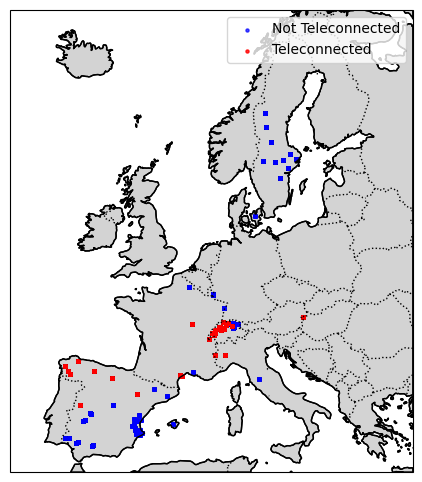

In [34]:
plot_teleconnection_map(
    df_total,
    teleco_col='teleco_PDSI_10'
)


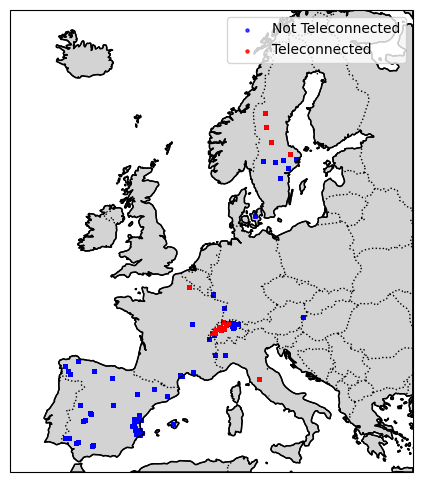

In [35]:
plot_teleconnection_map(
    df_total,
    teleco_col='teleco_precip_summer_10'
)

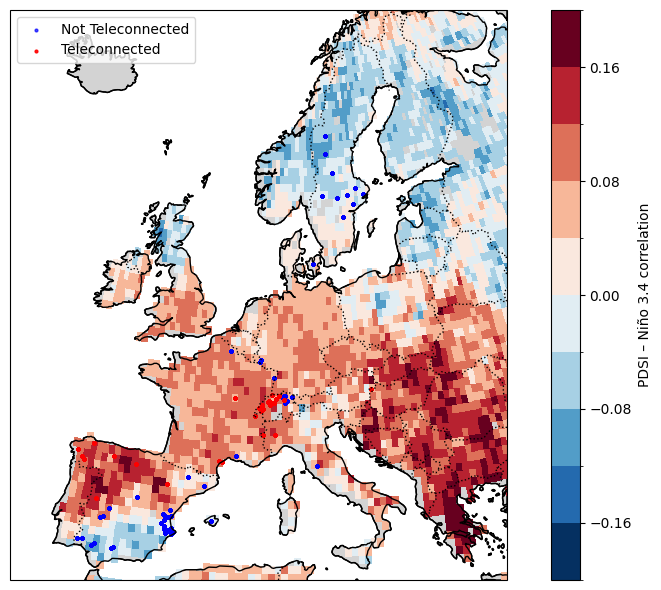

In [36]:
nino_xr = xr.Dataset.from_dataframe(enso.set_index("Year"))
plot_teleconnection_map_with_corr(
    owda=owda,         # your full OWDA xarray dataset (with PDSI_weighted)
    nino=nino_xr,      # your ENSO xarray.Dataset with .nino34 indexed by "Year"
    df=df_total,        # your DataFrame with 'lat', 'lon', and 'teleco'
    teleco_col='teleco_PDSI_10',
    title=""
)

In [37]:
df_total.groupby(['Year','Type']).agg({
    'teleco_PDSI_01': 'sum',
    'teleco_PDSI_05': 'sum',
    'teleco_PDSI_10': 'sum',
    'teleco_precip_summer_10': 'sum',
    'teleco_precip_winter_10': 'sum',
    'teleco_temp_summer_10': 'sum',
    'teleco_temp_winter_10': 'sum',
    'loc_id': 'nunique',
}).reset_index()

,Year,Type,teleco_PDSI_01,teleco_PDSI_05,teleco_PDSI_10,teleco_precip_summer_10,teleco_precip_winter_10,teleco_temp_summer_10,teleco_temp_winter_10,loc_id
0,1500,TI,0,7,24,22,4,0,8,46
1,1500,YR,1,3,5,2,6,0,0,12
2,1501,TI,0,7,24,22,4,0,8,46
3,1501,YR,1,3,5,2,6,0,0,12
4,1502,TI,0,7,24,22,4,0,8,46
...,...,...,...,...,...,...,...,...,...,...
852,1799,YI,0,0,0,0,2,0,0,1
853,1799,YR,1,3,5,2,8,0,0,13
854,1800,TI,0,7,23,22,4,0,8,60
855,1800,YI,0,0,0,0,2,0,0,1
